# 06_merge.ipynb

In [1]:
import pandas as pd
import geopandas as gpd
from dask.distributed import Client
import dask.dataframe as dd
from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt
import contextily as cx
from build_utilities import generate_variable_names, aggregate_crime_to_case_month
import dask_geopandas
INPUT_DATA_EVICTIONS = "../../data/02_intermediate/evictions.csv"
INPUT_DATA_TRACTS = "../../data/02_intermediate/tracts.csv"
INPUT_DATA_TAX_PARCELS = "../../data/02_intermediate/tax_parcels.gpkg"
INPUT_DATA_ZESTIMATES = "../../data/02_intermediate/zestimates.csv"
INPUT_DATA_CRIME = "../../data/01_raw/crime_incidents"
OUTPUT_DATA_UNRESTRICTED = "../../data/03_cleaned/unrestricted.csv"
OUTPUT_DATA_ZILLOW = "../../data/03_cleaned/zestimates_analysis.csv"
OUTPUT_DATA_CRIME = "../../data/03_cleaned/crime_analysis.csv"
VERBOSE = True
N_PARTITIONS = 1
value_vars_to_concat = []  # A list of DataFrames, where each DataFrame contains the panel data for a single outcome variable and has case_number as its index.

/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_19490/3404687922.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/lates

## 1. Loading Evictions Data

In [2]:
# Load evictions data.
with open(INPUT_DATA_EVICTIONS, 'r') as file:
    all_column_names = set(file.readline().replace("\"", "").replace("\n", "").split(","))
to_drop = {'Accuracy Score', 'Accuracy Type', 'Number', 'Street', 'Unit Type', 'Unit Number',
           'State', 'Zip', 'Country', 'Source', 'Census Year', 'State FIPS', 'County FIPS',
           'Place Name', 'Place FIPS', 'Census Tract Code', 'Census Block Code', 'Census Block Group',
           'Metro/Micro Statistical Area Code', 'Metro/Micro Statistical Area Type',
           'Combined Statistical Area Code', 'Metropolitan Division Area Code', 'court_location',
           'defendant', 'defendant_atty', 'defendant_atty_address_apt',
           'defendant_atty_address_city', 'defendant_atty_address_name', 'defendant_atty_address_state',
           'defendant_atty_address_street', 'defendant_atty_address_zip', 'docket_history', 'execution', 'judgment_for',
           'judgment_total', 'latest_docket_date', 'plaintiff', 'plaintiff_atty', 'plaintiff_atty_address_apt',
           'plaintiff_atty_address_city', 'plaintiff_atty_address_name', 'plaintiff_atty_address_state',
           'plaintiff_atty_address_street', 'plaintiff_atty_address_zip', 'Metropolitan Division Area Name',
           'property_address_city', 'property_address_state', 'property_address_street',
           'property_address_zip'}
evictions_df = pd.read_csv(INPUT_DATA_EVICTIONS, usecols=set(all_column_names) - set(to_drop))
original_N = len(evictions_df)
if VERBOSE:
    print(f"Beginning with {original_N} observations.")

# Drop cases missing file_date.
mask = evictions_df['file_date'].notna()
if VERBOSE:
    print(
        f"Dropping {(~mask).sum()} observations where file_date is missing.")
evictions_df = evictions_df.loc[mask, :]

# Add file month and year to dataset.
evictions_df.loc[:, 'file_month'] = pd.to_datetime(evictions_df['file_date']).dt.strftime('%Y-%m')
evictions_df.loc[:, 'file_year'] = pd.to_datetime(evictions_df['file_date']).dt.year

# Clean the values in the judgment_for_pdu variable.
judgment_for_pdu_replacement_dict = {"unknown": "Unknown",
                                     "plaintiff": "Plaintiff",
                                     "defendant": "Defendant"}
evictions_df.loc[:, "judgment_for_pdu"] = (evictions_df.loc[:, "judgment_for_pdu"]
                                           .replace(judgment_for_pdu_replacement_dict))

# Replace missing values in money judgment column with zeroes.
evictions_df.loc[:, 'judgment'] = evictions_df['judgment'].fillna(0)

# Rename duration to case_duration.
evictions_df = evictions_df.rename(columns={'duration': 'case_duration'})

# Drop malformed addresses.
if VERBOSE:
    print(f"Dropping {evictions_df['property_address_full'].str.contains('span, span span').sum()} observations which "
          f"have malformed addresses.")
evictions_df = evictions_df.loc[~evictions_df['property_address_full'].str.contains("span, span span"), :]

# Drop addresses without latitude and longitude.
if VERBOSE:
    print(f"Dropping {evictions_df[['longitude', 'latitude']].isna().any(axis=1).sum()} evictions missing latitude "
          f"or longitude.")
evictions_df = evictions_df.dropna(subset=['longitude', 'latitude'])

Beginning with 40759 observations.
Dropping 0 observations where file_date is missing.
Dropping 24 observations which have malformed addresses.
Dropping 1 evictions missing latitude or longitude.


## 2. Merging Evictions With Census Tract Characteristics

In [3]:
# Merge with census tract characteristics.
evictions_df = evictions_df.rename(columns={'Full FIPS (tract)': 'tract_geoid'})
evictions_tracts_df = evictions_df.merge(pd.read_csv(INPUT_DATA_TRACTS, dtype={'tract_geoid': float}),
                                  on='tract_geoid',
                                  how='left',
                                  validate='m:1').set_index('case_number')
if VERBOSE:
    print(f"Successfully merged {evictions_tracts_df['med_hhinc2016'].notna().sum()} observations with census tracts.")

Successfully merged 40732 observations with census tracts.


## 3. Merging Evictions With Zestimates

In [4]:
evictions_tracts_zestimates_df = pd.read_csv(INPUT_DATA_ZESTIMATES, index_col='case_number').merge(evictions_tracts_df,
                                                     right_index=True,
                                                     left_index=True,
                                                     how='right',
                                                     validate='1:1')
if VERBOSE:
    successfully_matched_observations = (~evictions_tracts_zestimates_df['2022-12'].isna()).sum()
    print(
        f"Successfully matched {successfully_matched_observations} evictions "
        f"({100 * (successfully_matched_observations / len(evictions_tracts_zestimates_df)) :.2f} percent of observations) to "
        f"Zestimates.")

# Rename columns containing Zestimates.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
value_vars_zestimates, _, _ = generate_variable_names('zestimate')
for value_var, value_var_zestimates in zip(value_vars, value_vars_zestimates):
    evictions_tracts_zestimates_df = evictions_tracts_zestimates_df.rename(columns={value_var: value_var_zestimates})
value_vars_to_concat.append(evictions_tracts_zestimates_df[value_vars_zestimates])

Successfully matched 11496 evictions (28.22 percent of observations) to Zestimates.


## 4. Merge Evictions with Crimes

In [5]:
# Request computing resources.
cluster = SLURMCluster(queue='batch',
                       cores=32,
                       memory='230 GB',
                       walltime='01:00:00',
                      scheduler_options={'dashboard_address': '8787'} )
cluster.scale(jobs=1)


In [6]:
client = Client(cluster)

In [7]:
# Create a GeoSeries containing eviction Points as its geometry, case_number as its index, and no other columns.
evictions_gdf = gpd.GeoDataFrame(evictions_df, geometry=gpd.points_from_xy(evictions_df['longitude'], evictions_df['latitude']))[['geometry', 'case_number']]
evictions_gdf = evictions_gdf.set_crs("EPSG:4326", allow_override=True).to_crs('EPSG:26986')

# Read crime data as Dask DataFrame, then compute back to DataFrame.
crime_df = (dd.read_csv(INPUT_DATA_CRIME + "/*.csv", dtype={'REPORTING_AREA': 'object', 'SHOOTING': 'object'})
                .dropna(subset=['Long', 'Lat', 'OCCURRED_ON_DATE'])  # Drop crimes missing latitude, longitude, or date, as they cannot be merged with panel.
                .rename(columns={'OCCURRED_ON_DATE': 'month_of_crime_incident'})
                .drop(columns=['OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING', 'YEAR', 'MONTH',
                               'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', 'Location'])  # Drop unneeded columns
                .compute())
                # Must call compute here and then briefly convert back to in-memory dataset because dask_geopandas.points_from_xy not working.
crime_df.loc[:, 'INCIDENT_NUMBER'] = 1  # Replace column with 1s so we can count crimes using sum function.
# Keep track of the month of crime incident in YYYY-MM format.
crime_df.loc[:, 'month_of_crime_incident'] = pd.to_datetime(crime_df['month_of_crime_incident'].str[:10]).dt.to_period("M").astype(str)
# Convert DataFrame to GeoDataFrame.
crime_gdf = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df['Long'], crime_df['Lat']))
crime_gdf = crime_gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:26986")  # Convert to the correct CRS.
# Convert GeoDataFrame to Dask GeoDataFrame.
crime_dgdf = dask_geopandas.from_geopandas(crime_gdf, npartitions=N_PARTITIONS).repartition(partition_size='25 MB')


# Create lists containing each group of offense codes.
violence_offense_codes = [801, 802,803, 423, 413, 401, 402, 403, 404, 411, 412, 413, 421, 422, 423, 424, 431, 432 ,433]
drug_offense_codes = [1870, 2609, 1874, 1842, 1841, 1849, 1848, 1858, 1855, 1864, 1863, 1866, 1868, 1843, 3023, 3021, 1875, 3022, 1847,
                      1840, 1873, 1843, 1844, 1845, 1846]
investigate_person_property = [3115, 3114]

columns_for_each_outcome = []
for offense_group_num, offense_group in enumerate(['all', violence_offense_codes, drug_offense_codes, investigate_person_property]):
    for radius in [50, 100, 150, 200]:
        # Create a new GeoDataFrame with geometry equal to circles around each eviction with the current radius.
        current_evictions_gdf = evictions_gdf.copy()
        current_evictions_gdf.geometry = current_evictions_gdf.geometry.buffer(radius)
        current_evictions_dgdf = dask_geopandas.from_geopandas(current_evictions_gdf, npartitions=N_PARTITIONS).repartition(partition_size='25 MB')

        # Merge evictions with crimes that fall into radius.
        current_evictions_crime_dgdf = dask_geopandas.sjoin(crime_dgdf, current_evictions_dgdf, how='inner', predicate='within')
        current_evictions_crime_dgdf = current_evictions_crime_dgdf.drop(columns=['geometry','index_right'])
        
        
        if offense_group != 'all':  # If we are summing a specific subcategory of crimes
            mask = current_evictions_crime_dgdf['OFFENSE_CODE'].isin(offense_group)
            # Multiply mask by 'INCIDENT_NUMBER' to zero out crimes in different offense groups.
            current_evictions_crime_dgdf['INCIDENT_NUMBER'] = current_evictions_crime_dgdf['INCIDENT_NUMBER'] * mask

            
        # Aggregate crimes to case-month level.
        current_panel_long = (current_evictions_crime_dgdf
                              .groupby(['case_number', 'month_of_crime_incident'])
                              .aggregate({'INCIDENT_NUMBER': 'sum'})
                              .reset_index()
                              .rename(columns={'INCIDENT_NUMBER': 'crime_incidents'})
                              .compute())

        current_panel_wide = pd.pivot(current_panel_long, index=['case_number'], columns=['month_of_crime_incident'],
                                      values='crime_incidents').reset_index().set_index('case_number')
        current_panel_wide.columns = [f'{column}_group_{offense_group_num}_crimes_{radius}m' for column in current_panel_wide.columns]
        columns_for_each_outcome.append(current_panel_wide.columns)
        value_vars_to_concat.append(dd.from_pandas(current_panel_wide, npartitions=N_PARTITIONS))
    

## 5. Producing the Unrestricted Dataset

In [8]:
unrestricted_df = dd.multi.concat([dd.from_pandas(evictions_tracts_df, npartitions=N_PARTITIONS)] + value_vars_to_concat, axis=1).compute()
# For evictions not matched to any crimes, fill NA values with 0.
for group_of_columns in columns_for_each_outcome:
    unrestricted_df[group_of_columns] = unrestricted_df[group_of_columns].fillna(0)
unrestricted_df.to_csv(OUTPUT_DATA_UNRESTRICTED)

## 6. Producing the Samples Used in Analysis

In [9]:
# Drop cases resolved via mediation.
mediated_mask = unrestricted_df['disposition_found'] == "Mediated"
if VERBOSE:
    print(f"Dropping {mediated_mask.sum()} cases resolved through mediation.")
unrestricted_df = unrestricted_df.loc[~mediated_mask, :]

Dropping 16883 cases resolved through mediation.


In [10]:
# Drop cases resolved via volntary dismissal (dropped by plaintiff). 
voluntary_dismissal_mask = unrestricted_df['disposition'].str.contains("R 41(a)(1) Voluntary Dismissal on", na=False, regex=False)
if VERBOSE:
    print(f"Droppping {voluntary_dismissal_mask.sum()} cases resolved through voluntary dismissal.")
unrestricted_df = unrestricted_df.loc[~voluntary_dismissal_mask, :]

Droppping 7455 cases resolved through voluntary dismissal.


In [11]:
# Drop cases where disposition found is other.
disposition_found_other_mask = unrestricted_df['disposition_found'] == "Other"
if VERBOSE:
    print(f"Dropping {disposition_found_other_mask.sum()} cases where disposition_found is \"Other\"")
unrestricted_df = unrestricted_df.loc[~disposition_found_other_mask, :]

Dropping 245 cases where disposition_found is "Other"


In [12]:
# Drop rows which contain consistent values of disposition_found and judgment_for_pdu.

# First, we drop cases where disposition_found is "Defaulted" but judgment_for_pdu is "Defendant"
inconsistent_mask_1 = ((unrestricted_df['disposition_found'] == "Defaulted") & (unrestricted_df['judgment_for_pdu'] == "Defendant"))
if VERBOSE:
    print(f"Dropping {inconsistent_mask_1.sum()} observations where disposition_found is \"Defaulted\" but judgment_for_pdu is \"Defendant\".")
unrestricted_df = unrestricted_df.loc[~inconsistent_mask_1, :]
          
# Next, we drop cases where disposition_found is "Dismissed" yet judgment_for_pdu is "Plaintiff"
inconsistent_mask_2 = ((unrestricted_df['disposition_found'] == "Dismissed") & (unrestricted_df['judgment_for_pdu'] == "Plaintiff"))
if VERBOSE:
    print(f"Dropping {inconsistent_mask_2.sum()} observations where disposition_found is \"Dismissed\" but judgment_for_pdu is \"Plaintiff\".")
unrestricted_df = unrestricted_df.loc[~inconsistent_mask_2, :]

Dropping 2 observations where disposition_found is "Defaulted" but judgment_for_pdu is "Defendant".
Dropping 150 observations where disposition_found is "Dismissed" but judgment_for_pdu is "Plaintiff".


In [13]:
# Generate a variable indicating judgment in favor of defendant.
unrestricted_df.loc[:, 'judgment_for_defendant'] = 0
defendant_won_mask = ((unrestricted_df['disposition_found'] == "Dismissed") |
                      (unrestricted_df['judgment_for_pdu'] == "Defendant"))
unrestricted_df.loc[defendant_won_mask, 'judgment_for_defendant'] = 1

# Generate a variable indicating judgement in favor of plaintiff.
unrestricted_df.loc[:, 'judgment_for_plaintiff'] = 1 - unrestricted_df['judgment_for_defendant']


### 6a. Producing the Zillow Sample

In [14]:
# Drop rows where we are missing any Zestimates.
zestimates_df = unrestricted_df.copy()
has_all_zestimates_mask = zestimates_df[value_vars_zestimates].notna().all(axis=1)
if VERBOSE:
    print(f"Limiting sample to {has_all_zestimates_mask.sum()} evictions for which we observe Zestimates at every month from 2012-12 to 2022-12.")
zestimates_df = zestimates_df.loc[has_all_zestimates_mask, :]
zestimates_df.to_csv(OUTPUT_DATA_ZILLOW)

Limiting sample to 3298 evictions for which we observe Zestimates at every month from 2012-12 to 2022-12.


### 6b. Producing the Crime Sample

In [15]:
crime_df = unrestricted_df.copy()
# Restrict to evictions which took place in Boston.
boston_mask = ((crime_df['County'] == "Suffolk County") & (~crime_df['City'].isin(["Chelsea", "Revere", "Winthrop"])))
if VERBOSE:
    print(f"Limiting sample to {boston_mask.sum()} observations which are in Boston.")
crime_df = crime_df.loc[boston_mask, :]
crime_df.to_csv(OUTPUT_DATA_CRIME)

Limiting sample to 2318 observations which are in Boston.


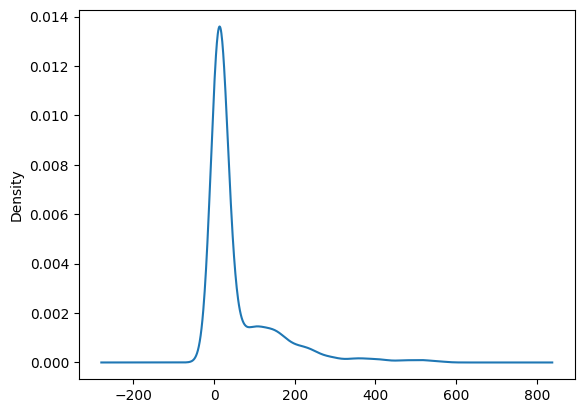

In [18]:
crime_df['case_duration'].plot(kind='kde')
plt.show()